In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 100)
from matplotlib import rcParams
rcParams['font.family'] = 'Noto Sans CJK JP'
%matplotlib inline

In [2]:
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")

/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
train_df.head()

,ID,種類,地域,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,土地の形状,間口,延床面積（㎡）,建築年,建物の構造,用途,今後の利用目的,前面道路：方位,前面道路：種類,前面道路：幅員（ｍ）,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log
0,8033256,中古マンション等,NaN,8203,茨城県,土浦市,川口,土浦,11,４ＬＤＫ,75,NaN,NaN,NaN,平成18年,ＲＣ,住宅,NaN,NaN,NaN,NaN,第２種住居地域,60.0,200.0,2009年第４四半期,未改装,NaN,7.255273
1,8041376,中古マンション等,NaN,8220,茨城県,つくば市,並木,つくば,30分?60分,３ＬＤＫ,80,NaN,NaN,NaN,平成20年,ＲＣ,住宅,NaN,NaN,NaN,NaN,第１種中高層住居専用地域,60.0,200.0,2010年第３四半期,改装済,NaN,7.278754
2,8003595,中古マンション等,NaN,8201,茨城県,水戸市,南町,水戸,13,１ＬＤＫ,70,NaN,NaN,NaN,NaN,ＳＲＣ,店舗,店舗,NaN,NaN,NaN,商業地域,80.0,400.0,2014年第４四半期,未改装,NaN,6.633468
3,8000968,中古マンション等,NaN,8201,茨城県,水戸市,大町,水戸,16,２ＬＤＫ,60,NaN,NaN,NaN,平成19年,ＳＲＣ,住宅,住宅,NaN,NaN,NaN,近隣商業地域,80.0,400.0,2019年第２四半期,未改装,NaN,7.204120
4,8044248,中古マンション等,NaN,8220,茨城県,つくば市,並木,つくば,30分?60分,３ＬＤＫ,80,NaN,NaN,NaN,平成20年,ＲＣ,住宅,住宅,NaN,NaN,NaN,第１種中高層住居専用地域,60.0,200.0,2017年第１四半期,未改装,NaN,7.301030


In [47]:
train_df.isnull().sum()

ID                   0
種類                   0
地域              662799
市区町村コード              0
都道府県名                0
市区町村名                0
地区名                658
最寄駅：名称            2650
最寄駅：距離（分）        23076
間取り              22954
面積（㎡）                0
土地の形状           662799
間口              662799
延床面積（㎡）         662799
建築年              19127
建物の構造            15595
用途               53943
今後の利用目的         363472
前面道路：方位         662799
前面道路：種類         662799
前面道路：幅員（ｍ）      662799
都市計画             18997
建ぺい率（％）          23050
容積率（％）           23050
取引時点                 0
改装               60076
取引の事情等          644339
取引価格（総額）_log         0
dtype: int64

/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='取引価格（総額）_log'>

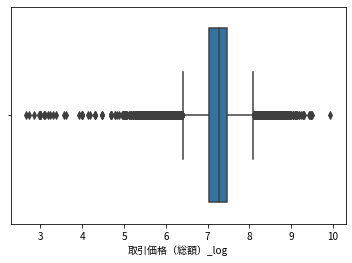

In [39]:
sns.boxplot(train_df["取引価格（総額）_log"])

In [42]:
len(train_df[train_df["取引価格（総額）_log"]<5])

57

In [45]:
len(train_df[train_df["取引価格（総額）_log"]>8.5])

249

In [46]:
train_df["用途"].unique()

array(['住宅', '店舗', nan, 'その他', '事務所', '住宅、店舗', '駐車場', '住宅、その他', '住宅、事務所',
       '住宅、駐車場', '店舗、その他', '事務所、店舗', '駐車場、店舗', '倉庫', '倉庫、店舗', '倉庫、駐車場',
       '作業場', '事務所、駐車場', '事務所、倉庫', '工場', '住宅、倉庫', '住宅、店舗、その他',
       '住宅、事務所、駐車場、店舗'], dtype=object)

In [ ]:
train_df["用途"].unique()

In [48]:
from contextlib import contextmanager
from time import time
from tqdm import tqdm
import re
from sklearn.preprocessing import LabelEncoder

def normalize_moyori(moyori):
    if moyori == moyori:
        if moyori == '30分?60分':
            moyori = 45
        elif moyori == '1H?1H30':
            moyori = 75
        elif moyori == '1H30?2H':
            moyori = 105
        elif moyori == '2H?':
            moyori = 120
        moyori = int(moyori)
    return moyori


# 面積情報の前処理関数
def normalize_area(area):
    if area == area:
        area = int(re.sub('m\^2未満|㎡以上', '', str(area)))
    return area


# 西暦情報に変換する関数
def convert_wareki_to_seireki(wareki):
    if wareki == wareki:
        if wareki == '戦前':
            wareki = '昭和20年'
        value = wareki[2:-1]
        if value == '元':
            value = 1
        else:
            value = int(value)
        if '昭和' in wareki:
            seireki = 1925+value
        elif '平成' in wareki:
            seireki = 1988+value
        elif '令和' in wareki:
            seireki = 2018+value
    else:
        seireki = wareki
    return seireki

def preprocess(input_df):
    output_df = input_df.copy()

    output_df['最寄駅：距離（分）'] = output_df['最寄駅：距離（分）'].apply(lambda x: normalize_moyori(x))
    output_df['面積（㎡）'] = output_df['面積（㎡）'].apply(lambda x: normalize_area(x))
    output_df['建築年'] = output_df['建築年'].apply(lambda x: convert_wareki_to_seireki(x))

    # 建ぺい率と容積率を変換
    output_df["建ぺい率（％）"] = output_df["建ぺい率（％）"] / 100
    output_df["容積率（％）"] = output_df["容積率（％）"] / 100

    # 取引時点の年数を算出
    output_df["取引時点"] = output_df['取引時点'].apply(lambda x: int(x[:4]))

    return output_df

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

# test
class BaseBlock(object):
    def fit(self, input_df, y=None):
        return self.transform(input_df)

    def transform(self, input_df):
        raise NotImplementedError()

class ContinuousBlock(BaseBlock):
    def __init__(self, column):
        self.column = column

    def transform(self, input_df):
        return input_df[self.column].copy()


class CountEncodingBlock(BaseBlock):
    def __init__(self, column, whole_df: pd.DataFrame):
        self.column = column
        self.whole_df = whole_df

    def transform(self, input_df):
        output_df = pd.DataFrame()
        c = self.column

        vc = self.whole_df[c].value_counts()
        output_df[c] = input_df[c].map(vc)
        return output_df.add_prefix("CE_")


class OheHotEncodingBlock(BaseBlock):
    def __init__(self, column, count_limit: int):
        self.column = column
        self.count_limit = count_limit

    def fit(self, input_df, y=None):
        vc = input_df[self.column].dropna().value_counts()
        cats_ = vc[vc > self.count_limit].index
        self.cats_ = cats_
        return self.transform(input_df)

    def transform(self, input_df):
        x = pd.Categorical(input_df[self.column], categories=self.cats_)
        output_df = pd.get_dummies(x, dummy_na=False)
        output_df.columns = output_df.columns.to_list()
        return output_df.add_prefix(f'OHE_{self.column}=')


class LabelEncodingBlock(BaseBlock):
    def __init__(self, column: str, whole_df: pd.DataFrame):
        self.column = column
        self.le = LabelEncoder()
        self.whole_df = whole_df

    def fit(self, input_df, y=None):
        self.le.fit(self.whole_df[self.column].fillna("nan"))
        return self.transform(input_df)

    def transform(self, input_df):
        c = self.column
        output_df = input_df.copy()
        output_df[c] = self.le.transform(input_df[c].fillna("nan")).astype("int")
        output_df = output_df[[c]]
        return output_df.add_prefix(f"LE_")


class WrapperBlock(BaseBlock):
    def __init__(self, function):
        self.function = function

    def transform(self, input_df):
        return self.function(input_df)


# 特定カラムの四則演算
class ArithmeticOperationBlock(BaseBlock):
    def __init__(self, target_column1: str, target_column2: str, operation: str):
        self.target_column1 = target_column1
        self.target_column2 = target_column2
        self.operation = operation

    def fit(self, input_df, y=None):
        return self.transform(input_df)

    def transform(self, input_df):
        output_df = input_df.copy()
        output_df_columns_name = f'{self.target_column1}{self.operation}{self.target_column2}'

        if self.operation == "+":
            output_df[output_df_columns_name] = output_df[self.target_column1] + output_df[self.target_column2]

        elif self.operation == "-":
            output_df[output_df_columns_name] = output_df[self.target_column1] - output_df[self.target_column2]

        elif self.operation == "*":
            output_df[output_df_columns_name] = output_df[self.target_column1] * output_df[self.target_column2]

        elif self.operation == "/":
            output_df[output_df_columns_name] = output_df[self.target_column1] / output_df[self.target_column2]

        return output_df[output_df_columns_name]


class AggregationBlock(BaseBlock):
    def __init__(self, whole_df: pd.DataFrame,
                 key: str,
                 agg_column: str,
                 agg_funcs: ["mean"],
                 fillna=None):
        self.whole_df = whole_df
        self.key = key
        self.agg_column = agg_column
        self.agg_funcs = agg_funcs
        self.fillna = fillna

    def fit(self, input_df):
        return self.transform(input_df)

    def transform(self, input_df):
        if self.fillna:
            self.whole_df[self.agg_column] = self.whole_df[self.agg_column].fillna(self.fillna)

        self.group_df = self.whole_df.groupby(self.key).agg({self.agg_column: self.agg_funcs}).reset_index()
        column_names = [f'GP_{self.agg_column}@{self.key}_{agg_func}' for agg_func in self.agg_funcs]

        self.group_df.columns = [self.key] + column_names
        output_df = pd.merge(input_df[self.key], self.group_df, on=self.key, how="left").drop(columns=[self.key])
        return output_df

class AgeBlock(BaseBlock):
    def __init__(self, column: str):
        self.column = column

    def fit(self, input_df, y=None):
        return self.transform(input_df)

    def transform(self, input_df):
        output_df = input_df.copy()
        output_df_col_name = f'Age@{self.column}'

        output_df[output_df_col_name] = 2021 - input_df[self.column]

        return output_df[output_df_col_name]


class TargetEncodingBlock(BaseBlock):
    def __init__(self, column:str, target_column:str, agg_funcs:str=['mean']):
        self.column = column
        self.target_column = target_column
        self.agg_funcs = agg_funcs

    def fit(self, input_df):
        self.target_map = input_df.groupby(self.column)[self.target_column].agg(self.agg_funcs)
        
        output_encoded = np.zeros((len(input_df), len(self.agg_funcs)))
        kf = KFold(n_splits=4, shuffle=True, random_state=1000)
        for index, agg_func in enumerate(self.agg_funcs):
            for train_idx, valid_idx in kf.split(input_df):
                target_map = input_df.iloc[train_idx].groupby(self.column)[self.target_column].agg(self.agg_funcs)
                output_encoded[valid_idx, index] = input_df.iloc[valid_idx][self.column].map(target_map[agg_func].to_dict())
        
        output_encoded = pd.DataFrame(output_encoded)
        output_encoded.columns = [f'TE_{self.column}_{self.target_column}_{agg_func}' for agg_func in self.agg_funcs]
        return output_encoded
    
    def transform(self, input_df):
        output_encoded = np.zeros((len(input_df), len(self.agg_funcs)))
        for index, agg_func in enumerate(self.agg_funcs):        
            output_encoded[:,index] = input_df[self.column].map(self.target_map['mean'].to_dict()).values
            
        output_encoded = pd.DataFrame(output_encoded)
        output_encoded.columns = [f'TE_{self.column}_{self.target_column}_{agg_func}' for agg_func in self.agg_funcs]
        return output_encoded

@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)


def get_function(block, is_train):
    s = mapping = {
        True: 'fit',
        False: 'transform'
    }.get(is_train)
    return getattr(block, s)


def to_feature(input_df,
               blocks,
               is_train=False):
    out_df = pd.DataFrame()

    for block in tqdm(blocks, total=len(blocks)):
        func = get_function(block, is_train)

        with timer(prefix='create ' + str(block) + ' '):
            _df = func(input_df)
        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
    return reduce_mem_usage(out_df)


In [83]:
# station block
class StationInfoBlock(BaseBlock):
    def __init__(self, columns:str):
        self.columns = columns
        
        
    def transform(self, input_df):
        output_df = pd.DataFrame()
        station_df = pd.read_csv("../add/station.csv").drop_duplicates("最寄駅：名称")
        _df = pd.merge(input_df, station_df, on="最寄駅：名称", how="left")
        
        c = self.columns

        vc = _df[c].value_counts()
        output_df[c] = _df[c].map(vc)
        return output_df.add_prefix("CE_")

In [68]:
train = preprocess(train_df)
test = preprocess(test_df)
whole_df = pd.concat([train, test],axis=0)

In [86]:
print(len(train))
print(len(pd.merge(train, pd.read_csv("../add/station.csv").drop_duplicates("最寄駅：名称"), on="最寄駅：名称", how="left")))

662799
662799


In [82]:
pd.merge(train, pd.read_csv("../add/station.csv").drop_duplicates("最寄駅：名称"), on="最寄駅：名称", how="left")

,ID,種類,地域,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,土地の形状,間口,延床面積（㎡）,建築年,建物の構造,用途,今後の利用目的,前面道路：方位,前面道路：種類,前面道路：幅員（ｍ）,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log,運営会社,路線名,乗降客数18
0,8033256,中古マンション等,NaN,8203,茨城県,土浦市,川口,土浦,11.0,４ＬＤＫ,75,NaN,NaN,NaN,2006.0,ＲＣ,住宅,NaN,NaN,NaN,NaN,第２種住居地域,0.6,2.0,2009,未改装,NaN,7.255273,東日本旅客鉄道,常磐線,32248.0
1,8041376,中古マンション等,NaN,8220,茨城県,つくば市,並木,つくば,45.0,３ＬＤＫ,80,NaN,NaN,NaN,2008.0,ＲＣ,住宅,NaN,NaN,NaN,NaN,第１種中高層住居専用地域,0.6,2.0,2010,改装済,NaN,7.278754,首都圏新都市鉄道,常磐新線,36400.0
2,8003595,中古マンション等,NaN,8201,茨城県,水戸市,南町,水戸,13.0,１ＬＤＫ,70,NaN,NaN,NaN,NaN,ＳＲＣ,店舗,店舗,NaN,NaN,NaN,商業地域,0.8,4.0,2014,未改装,NaN,6.633468,鹿島臨海鉄道,大洗鹿島線,63887.0
3,8000968,中古マンション等,NaN,8201,茨城県,水戸市,大町,水戸,16.0,２ＬＤＫ,60,NaN,NaN,NaN,2007.0,ＳＲＣ,住宅,住宅,NaN,NaN,NaN,近隣商業地域,0.8,4.0,2019,未改装,NaN,7.204120,鹿島臨海鉄道,大洗鹿島線,63887.0
4,8044248,中古マンション等,NaN,8220,茨城県,つくば市,並木,つくば,45.0,３ＬＤＫ,80,NaN,NaN,NaN,2008.0,ＲＣ,住宅,住宅,NaN,NaN,NaN,第１種中高層住居専用地域,0.6,2.0,2017,未改装,NaN,7.301030,首都圏新都市鉄道,常磐新線,36400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662794,3005573,中古マンション等,NaN,3201,岩手県,盛岡市,東山,盛岡,45.0,２ＬＤＫ,65,NaN,NaN,NaN,1992.0,ＲＣ,住宅,住宅,NaN,NaN,NaN,第２種中高層住居専用地域,0.6,2.0,2017,改装済,NaN,6.949390,アイジーアールいわて銀河鉄道,いわて銀河鉄道線,11593.0
662795,3005930,中古マンション等,NaN,3201,岩手県,盛岡市,茶畑,盛岡,45.0,２ＬＤＫ,70,NaN,NaN,NaN,1985.0,ＲＣ,住宅,NaN,NaN,NaN,NaN,第１種住居地域,0.6,2.0,2013,未改装,調停・競売等,6.799341,アイジーアールいわて銀河鉄道,いわて銀河鉄道線,11593.0
662796,3015560,中古マンション等,NaN,3201,岩手県,盛岡市,材木町,盛岡,8.0,１Ｋ,70,NaN,NaN,NaN,1985.0,ＳＲＣ,店舗,NaN,NaN,NaN,NaN,商業地域,0.8,4.0,2009,未改装,調停・競売等,6.255273,アイジーアールいわて銀河鉄道,いわて銀河鉄道線,11593.0
662797,3003542,中古マンション等,NaN,3201,岩手県,盛岡市,中央通,盛岡,8.0,２ＤＫ,40,NaN,NaN,NaN,1984.0,ＳＲＣ,住宅,住宅,NaN,NaN,NaN,商業地域,0.8,4.0,2017,未改装,NaN,6.812913,アイジーアールいわて銀河鉄道,いわて銀河鉄道線,11593.0


In [87]:
from sklearn.model_selection import KFold


process_blocks=[*[StationInfoBlock(columns=c) for c in ["運営会社","路線名"]]]


train_x = to_feature(train, process_blocks, is_train=True)
test_x = to_feature(test, process_blocks)

 50%|█████     | 1/2 [00:00<00:00,  1.58it/s]

create <__main__.StationInfoBlock object at 0x7f68962b9630> 0.632[s]


100%|██████████| 2/2 [00:00<00:00, 33.36it/s]

create <__main__.StationInfoBlock object at 0x7f68962b9438> 0.569[s]
Memory usage of dataframe is 15.17 MB
Memory usage after optimization is: 8.85 MB
Decreased by 41.7%
create <__main__.StationInfoBlock object at 0x7f68962b9630> 0.031[s]
create <__main__.StationInfoBlock object at 0x7f68962b9438> 0.028[s]
Memory usage of dataframe is 0.53 MB
Memory usage after optimization is: 0.27 MB
Decreased by 50.0%


In [88]:
train_x

,CE_運営会社,CE_路線名
0,90219.0,6256.0
1,4298.0,4296.0
2,452.0,452.0
3,452.0,452.0
4,4298.0,4296.0
...,...,...
662794,1069.0,1069.0
662795,1069.0,1069.0
662796,1069.0,1069.0
662797,1069.0,1069.0


In [34]:
test_x

,TE_都道府県名_取引価格（総額）_log_mean,TE_市区町村名_取引価格（総額）_log_mean,TE_地区名_取引価格（総額）_log_mean,TE_最寄駅：名称_取引価格（総額）_log_mean,TE_間取り_取引価格（総額）_log_mean,TE_建物の構造_取引価格（総額）_log_mean,TE_用途_取引価格（総額）_log_mean,TE_今後の利用目的_取引価格（総額）_log_mean,TE_都市計画_取引価格（総額）_log_mean,TE_改装_取引価格（総額）_log_mean
0,6.984375,7.046875,6.929688,7.042969,7.332031,7.167969,7.21875,7.269531,7.238281,7.222656
1,6.984375,7.046875,6.929688,7.042969,7.332031,7.167969,7.21875,7.132812,7.238281,7.222656
2,6.984375,7.046875,6.929688,7.042969,7.304688,7.167969,7.21875,7.269531,7.238281,7.222656
3,6.984375,7.046875,6.929688,7.042969,7.304688,7.246094,NaN,7.269531,7.238281,7.222656
4,6.984375,7.046875,6.929688,7.042969,7.019531,7.246094,NaN,7.269531,7.238281,7.222656
...,...,...,...,...,...,...,...,...,...,...
23199,7.203125,7.230469,7.332031,NaN,7.285156,7.246094,NaN,7.269531,7.179688,7.222656
23200,7.203125,7.031250,6.937500,NaN,7.335938,7.246094,NaN,7.269531,7.179688,7.222656
23201,7.203125,7.031250,6.792969,NaN,7.304688,7.246094,NaN,7.269531,7.320312,NaN
23202,7.203125,7.031250,7.191406,NaN,7.304688,7.246094,NaN,7.269531,6.890625,7.222656


In [49]:
l = LabelEncoder()
l.fit(whole_df["今後の利用目的"].)

LabelEncoder()

In [53]:
whole_df["今後の利用目的"].unique()

[NaN, '店舗', '住宅', 'その他', '事務所']
Categories (4, object): ['店舗', '住宅', 'その他', '事務所']

cmss10
Lohit Tamil
STIXSizeFourSym
Liberation Sans Narrow
Chandas
Jamrul
ori1Uni
mry_KacstQurn
Norasi
DejaVu Serif
Nimbus Mono PS
Tlwg Typist
URW Bookman
DejaVu Sans Mono
Standard Symbols PS
Tibetan Machine Uni
AnjaliOldLipi
Manjari
cmtt10
Lohit Telugu
KacstQurn
KacstPen
Abyssinica SIL
Mitra Mono
STIXGeneral
RaghuMalayalamSans
Uroob
Keraleeyam
Purisa
Khmer OS
Liberation Serif
KacstFarsi
KacstBook
Tlwg Mono
Ubuntu Condensed
Samyak Malayalam
Liberation Sans
cmb10
KacstScreen
KacstLetter
Z003
cmr10
Tlwg Typewriter
KacstOne
STIXSizeFiveSym
Meera
Samyak Gujarati
STIXSizeOneSym
Liberation Mono
Lohit Bengali
Chilanka
Lohit Tamil Classical
cmsy10
KacstDecorative
URW Gothic
Padauk
DejaVu Sans Display
padmaa-Bold.1.1
KacstNaskh
Lohit Odia
Waree
KacstArt
Khmer OS System
Kinnari
Lohit Kannada
Noto Serif CJK JP
Pothana2000
Rachana
Kalimati
Ubuntu
Umpush
cmex10
Rekha
aakar
STIXSizeThreeSym
Droid Sans Fallback
OpenSymbol
Laksaman
Mukti Narrow
Gubbi
DejaVu Math TeX Gyre
FreeSans
Ubuntu Mono
Phetsarath

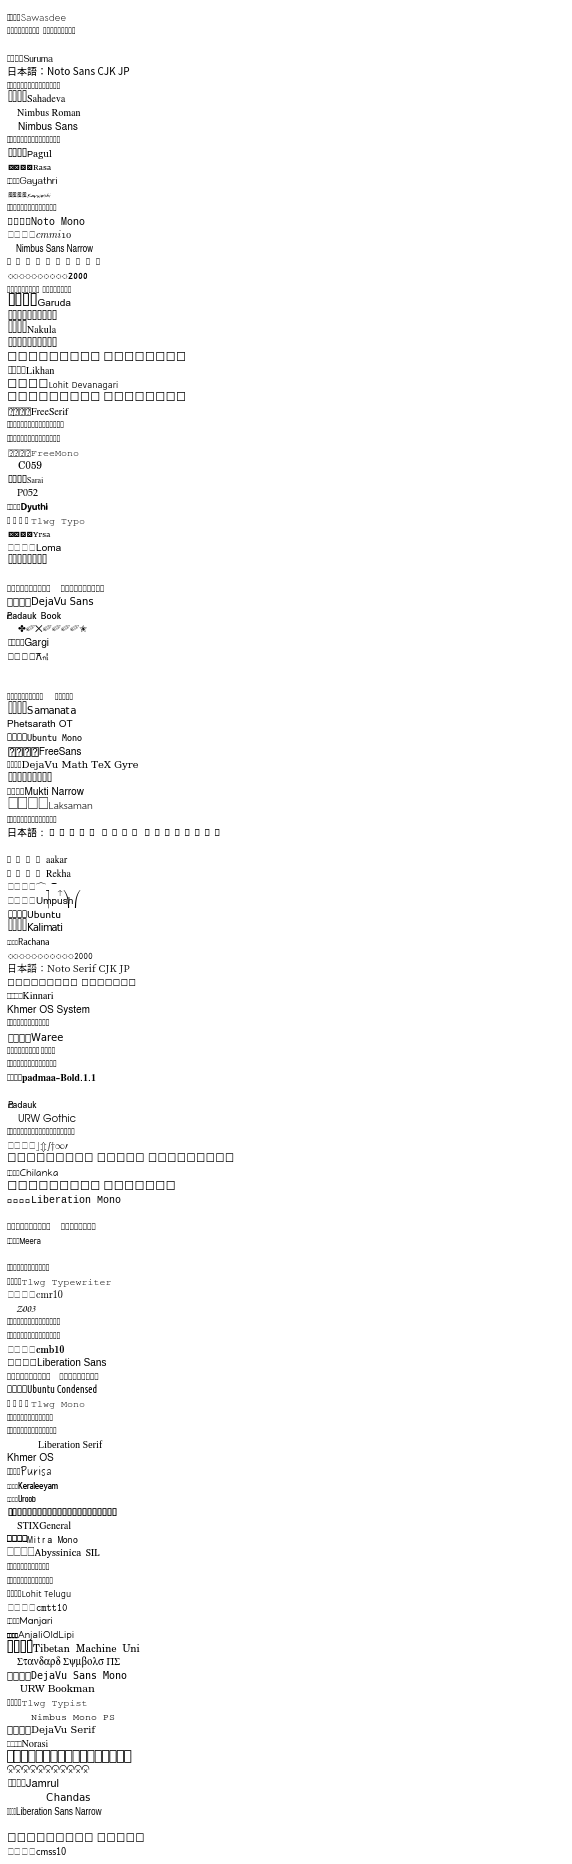

In [81]:
fonts = set([f.name for f in matplotlib.font_manager.fontManager.ttflist])
 
# 描画領域のサイズ調整
plt.figure(figsize=(10,len(fonts)/4))
 
# フォントの表示
for i, font in enumerate(fonts):
    print(font)
    plt.text(0, i, f"日本語：{font}", fontname=font)
    
# 見やすいように軸を消す
plt.ylim(0, len(fonts))
plt.axis("off")
    
plt.show()

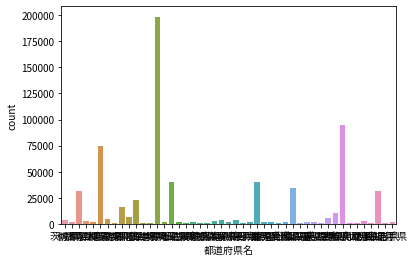

In [82]:
import seaborn as sns

import matplotlib.pyplot as plt
rcParams['font.family'] = 'Noto Sans CJK JP'


sns.countplot(x=train_df["都道府県名"])
plt.show()

In [66]:
train.shape

(662799, 28)

In [67]:
train_x.shape

(662799, 38)

In [68]:
train

,ID,種類,地域,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,土地の形状,間口,延床面積（㎡）,建築年,建物の構造,用途,今後の利用目的,前面道路：方位,前面道路：種類,前面道路：幅員（ｍ）,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log
0,8033256,中古マンション等,NaN,8203,茨城県,土浦市,川口,土浦,11.0,４ＬＤＫ,75,NaN,NaN,NaN,2006.0,ＲＣ,住宅,NaN,NaN,NaN,NaN,第２種住居地域,0.6,2.0,2009,未改装,NaN,7.255273
1,8041376,中古マンション等,NaN,8220,茨城県,つくば市,並木,つくば,45.0,３ＬＤＫ,80,NaN,NaN,NaN,2008.0,ＲＣ,住宅,NaN,NaN,NaN,NaN,第１種中高層住居専用地域,0.6,2.0,2010,改装済,NaN,7.278754
2,8003595,中古マンション等,NaN,8201,茨城県,水戸市,南町,水戸,13.0,１ＬＤＫ,70,NaN,NaN,NaN,NaN,ＳＲＣ,店舗,店舗,NaN,NaN,NaN,商業地域,0.8,4.0,2014,未改装,NaN,6.633468
3,8000968,中古マンション等,NaN,8201,茨城県,水戸市,大町,水戸,16.0,２ＬＤＫ,60,NaN,NaN,NaN,2007.0,ＳＲＣ,住宅,住宅,NaN,NaN,NaN,近隣商業地域,0.8,4.0,2019,未改装,NaN,7.204120
4,8044248,中古マンション等,NaN,8220,茨城県,つくば市,並木,つくば,45.0,３ＬＤＫ,80,NaN,NaN,NaN,2008.0,ＲＣ,住宅,住宅,NaN,NaN,NaN,第１種中高層住居専用地域,0.6,2.0,2017,未改装,NaN,7.301030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662794,3005573,中古マンション等,NaN,3201,岩手県,盛岡市,東山,盛岡,45.0,２ＬＤＫ,65,NaN,NaN,NaN,1992.0,ＲＣ,住宅,住宅,NaN,NaN,NaN,第２種中高層住居専用地域,0.6,2.0,2017,改装済,NaN,6.949390
662795,3005930,中古マンション等,NaN,3201,岩手県,盛岡市,茶畑,盛岡,45.0,２ＬＤＫ,70,NaN,NaN,NaN,1985.0,ＲＣ,住宅,NaN,NaN,NaN,NaN,第１種住居地域,0.6,2.0,2013,未改装,調停・競売等,6.799341
662796,3015560,中古マンション等,NaN,3201,岩手県,盛岡市,材木町,盛岡,8.0,１Ｋ,70,NaN,NaN,NaN,1985.0,ＳＲＣ,店舗,NaN,NaN,NaN,NaN,商業地域,0.8,4.0,2009,未改装,調停・競売等,6.255273
662797,3003542,中古マンション等,NaN,3201,岩手県,盛岡市,中央通,盛岡,8.0,２ＤＫ,40,NaN,NaN,NaN,1984.0,ＳＲＣ,住宅,住宅,NaN,NaN,NaN,商業地域,0.8,4.0,2017,未改装,NaN,6.812913


In [69]:
train_x

,建ぺい率（％）,容積率（％）,面積（㎡）,最寄駅：距離（分）,建築年,市区町村コード,CE_都道府県名,CE_市区町村名,CE_地区名,CE_最寄駅：名称,CE_間取り,CE_建物の構造,CE_用途,CE_今後の利用目的,CE_都市計画,CE_改装,CE_取引の事情等,LE_都道府県名,Age@建築年,Age@取引時点,面積（㎡）*建ぺい率（％）,面積（㎡）*容積率（％）,GP_最寄駅：距離（分）@最寄駅：名称_mean,GP_最寄駅：距離（分）@最寄駅：名称_std,GP_最寄駅：距離（分）@最寄駅：名称_max,GP_最寄駅：距離（分）@最寄駅：名称_min,GP_面積（㎡）@最寄駅：名称_mean,GP_面積（㎡）@最寄駅：名称_std,GP_面積（㎡）@最寄駅：名称_max,GP_面積（㎡）@最寄駅：名称_min,GP_建ぺい率（％）@最寄駅：名称_mean,GP_建ぺい率（％）@最寄駅：名称_std,GP_建ぺい率（％）@最寄駅：名称_max,GP_建ぺい率（％）@最寄駅：名称_min,GP_容積率（％）@最寄駅：名称_mean,GP_容積率（％）@最寄駅：名称_std,GP_容積率（％）@最寄駅：名称_max,GP_容積率（％）@最寄駅：名称_min
0,0.600098,2.0,75,11.0,2006.0,8203,3487,527,507.0,437.0,62348.0,463666.0,617532.0,NaN,31587.0,448401.0,NaN,38,15.0,12,45.0,150.0,17.265625,23.156250,120.0,2.0,66.0000,13.640625,105.0,15.0,0.698242,0.100098,0.799805,0.600098,3.244141,1.400391,6.0,1.500000
1,0.600098,2.0,80,45.0,2008.0,8220,3487,633,1102.0,501.0,291706.0,463666.0,617532.0,NaN,106721.0,174406.0,NaN,38,13.0,11,48.0,160.0,27.593750,21.000000,75.0,4.0,84.5000,19.734375,390.0,55.0,0.667480,0.095337,0.799805,0.500000,2.386719,0.790039,4.0,2.000000
2,0.799805,4.0,70,13.0,NaN,8201,3487,623,1448.0,464.0,29288.0,199431.0,2957.0,1206.0,186992.0,448401.0,NaN,38,NaN,7,56.0,280.0,20.859375,14.914062,75.0,2.0,66.3750,27.250000,440.0,15.0,0.734375,0.099426,0.799805,0.399902,3.457031,1.328125,6.0,0.799805
3,0.799805,4.0,60,16.0,2007.0,8201,3487,623,348.0,464.0,99045.0,199431.0,617532.0,298576.0,69126.0,448401.0,NaN,38,14.0,2,48.0,240.0,20.859375,14.914062,75.0,2.0,66.3750,27.250000,440.0,15.0,0.734375,0.099426,0.799805,0.399902,3.457031,1.328125,6.0,0.799805
4,0.600098,2.0,80,45.0,2008.0,8220,3487,633,1102.0,501.0,291706.0,463666.0,617532.0,298576.0,106721.0,448401.0,NaN,38,13.0,4,48.0,160.0,27.593750,21.000000,75.0,4.0,84.5000,19.734375,390.0,55.0,0.667480,0.095337,0.799805,0.500000,2.386719,0.790039,4.0,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662794,0.600098,2.0,65,45.0,1992.0,3201,1360,1279,349.0,1089.0,99045.0,463666.0,617532.0,298576.0,31474.0,174406.0,NaN,19,29.0,4,39.0,130.0,21.796875,17.531250,120.0,2.0,58.1875,63.031250,2000.0,15.0,0.759766,0.080322,0.799805,0.600098,3.613281,1.234375,10.0,2.000000
662795,0.600098,2.0,70,45.0,1985.0,3201,1360,1279,23.0,1089.0,99045.0,463666.0,617532.0,NaN,104806.0,448401.0,17488.0,19,36.0,8,42.0,140.0,21.796875,17.531250,120.0,2.0,58.1875,63.031250,2000.0,15.0,0.759766,0.080322,0.799805,0.600098,3.613281,1.234375,10.0,2.000000
662796,0.799805,4.0,70,8.0,1985.0,3201,1360,1279,170.0,1089.0,100611.0,199431.0,2957.0,NaN,186992.0,448401.0,17488.0,19,36.0,12,56.0,280.0,21.796875,17.531250,120.0,2.0,58.1875,63.031250,2000.0,15.0,0.759766,0.080322,0.799805,0.600098,3.613281,1.234375,10.0,2.000000
662797,0.799805,4.0,40,8.0,1984.0,3201,1360,1279,118.0,1089.0,21778.0,199431.0,617532.0,298576.0,186992.0,448401.0,NaN,19,37.0,4,32.0,160.0,21.796875,17.531250,120.0,2.0,58.1875,63.031250,2000.0,15.0,0.759766,0.080322,0.799805,0.600098,3.613281,1.234375,10.0,2.000000
